# Convolution and cross-correlation

In [1]:
import headerfooter
headerfooter.header()

This notebook is a study about the closely related mathematical concepts of *convolution* and *cross-correlation*, which are very important for signal processing theory (the focus here). These operators take two continuous or discrete functions as input and produce a third function that may represent things like

* The similarity of two functions
* The smoothing of a function by a kernel
* The sharpening of certain function features

to name a few. After a few preliminary defintions, the examples will focus on the constructive comprehension of the meaning of these operators.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notebook-setup" data-toc-modified-id="Notebook-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notebook setup</a></span></li><li><span><a href="#Definitions" data-toc-modified-id="Definitions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Definitions</a></span><ul class="toc-item"><li><span><a href="#Discrete-domain" data-toc-modified-id="Discrete-domain-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Discrete domain</a></span></li></ul></li><li><span><a href="#Convolution-examples" data-toc-modified-id="Convolution-examples-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Convolution examples</a></span><ul class="toc-item"><li><span><a href="#Point-impulse" data-toc-modified-id="Point-impulse-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Point-impulse</a></span></li><li><span><a href="#Weighted-sum" data-toc-modified-id="Weighted-sum-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Weighted sum</a></span></li><li><span><a href="#Feature-detection" data-toc-modified-id="Feature-detection-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Feature detection</a></span><ul class="toc-item"><li><span><a href="#Edge-detection-(derivatives)" data-toc-modified-id="Edge-detection-(derivatives)-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Edge detection (derivatives)</a></span></li></ul></li></ul></li><li><span><a href="#Correlation-examples" data-toc-modified-id="Correlation-examples-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Correlation examples</a></span><ul class="toc-item"><li><span><a href="#Positive-lag-analysis" data-toc-modified-id="Positive-lag-analysis-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Positive lag analysis</a></span></li></ul></li><li><span><a href="#TODO" data-toc-modified-id="TODO-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>TODO</a></span></li></ul></div>

## Notebook setup

In [2]:
%matplotlib inline

In [3]:
import ipywidgets as ipw
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy.signal as ss

## Definitions

The convolution of continuous functions $f, g$ is defined as

$$(f * g)(\tau) = \int_{-\infty}^{\infty} \bar{f}(t) \, g(\tau - t) \, {\rm d}t$$

whereas their cross-correlation is defined as

$$(f \star g)(\tau) = \int_{-\infty}^{\infty} \bar{f}(t) \, g(\tau + t) \, {\rm d}t$$

The following identity follows from these definitions

$$f(t) \star g(t) = \bar{f}(-t) * g(t)$$

### Discrete domain

In the discrete domain, the convolution of the time series $x,y$ becomes

$$(x * y)_m = \sum_{n=-\infty}^{\infty} \bar{x}_n \, y_{m - n}$$

and their cross-correlation

$$(x \star y)_m = \sum_{n=-\infty}^{\infty} \bar{x}_n \, y_{m + n}$$

Still, a similar identity holds:

$$x_n \star y_n = \bar{x}_{-n} * y_n$$

## Convolution examples

Naturally, our examples need to be in the discrete domain. Additionally, we will only present examples of real-valued functions, so we can assume that $\bar{x} = x$ and simplify all equations based on this assumption.

### Point-impulse

Let's start with an arbitrary signal $x$ and convolve it with the simplest possible kernel 

$$
y_n = 
    \begin{cases}
        1, {\rm if}\, n = 0 \\
        0, {\rm otherwise}
    \end{cases}
$$

which corresponds to the discrete version of a $\delta$ function.

In [4]:
def convolution_impulse(n, seed):
    npr.seed(seed)
    
    x = npr.random(n)
    y = np.array([1])
    z = np.convolve(x, y, mode='same')
    
    fig = plt.figure()
    axes = fig.subplots(3, 1, sharex=True, sharey=True)
    
    axes[0].plot(x, 'o-')
    axes[0].grid()
    axes[0].set_ylabel('Input ($x$)')
    
    axes[1].stem(y, linefmt='C0--', markerfmt='o')
    axes[1].grid()
    axes[1].set_ylabel('Impulse ($y$)')
    
    axes[2].plot(z, 'o-')
    axes[2].grid()
    axes[2].set_xlabel('Time ($n$)')
    axes[2].set_ylabel('Response ($x * y$)')
    
    plt.show(fig)
    plt.close(fig)
    
ipw.interact(
    convolution_impulse,
    n=ipw.IntText(10, description='Points:'),
    seed=ipw.IntText(1234, description='Rand. seed'),
)

interactive(children=(IntText(value=10, description='Points:'), IntText(value=1234, description='Rand. seed'),…

<function __main__.convolution_impulse(n, seed)>

In this case, no matter the length of the input signal, it is pretty obvious that the result equals the original signal. It couldn't be any different, after all

$$
z_m = 
    \sum_{n=-\infty}^{\infty} x_n \, y_{m-n} = 
    \sum_{n=-\infty}^{\infty} x_n \,
        \left\{ \begin{array}{ll}
            1, &\rm{if}\, m = n \\
            0, &\rm{otherwise}
        \end{array} \right\} = 
    x_m
$$

### Weighted sum

A slightly more involved case consists in changing $y$ for a weighted average of the central point and of the 2 neighboring points

$$
\begin{array}{cccccc}
    n   & -\infty & -2 & -1    & 0   & 1    & 2 & \infty \\
    y_n & \ldots  &  0 &  0.15 & 0.5 & 0.35 & 0 & \ldots
\end{array}
$$

Notice that the sum of weights equals 1, which would correspond, in the continuous domain, to the condition 

$$\int_{-\infty}^{\infty} y \, {\rm d}t = 1$$

In [5]:
def convolution_weighted_sum(n, a, b, c, seed=1234):
    npr.seed(seed)
    
    x = npr.random(n)
    y = np.array([a, b, c])
    y = y / np.sum(y)
    z = np.convolve(x, y, mode='same')
    
    fig = plt.figure()
    axes = fig.subplots(3, 1, sharex=True, sharey=True)
    
    for ax in axes:
        ax.axvline(0, color='k', alpha=0.3)
        ax.set_xlim(-1, n)
        ax.set_ylim(0, 1)
        ax.grid()
    
    axes[0].plot(x, 'o-')
    axes[0].set_ylabel('Input ($x$)')
    
    axes[1].stem([-1, 0, 1], y, basefmt='none', linefmt='C0--', markerfmt='o')
    axes[1].set_ylabel('Impulse ($y$)')
    
    axes[2].plot(z, 'o-')
    axes[2].set_xlabel('Time ($n$)')
    axes[2].set_ylabel('Response\n($z=x * y$)')
    
    plt.show(fig)
    plt.close(fig)
    
ipw.interact(
    convolution_weighted_sum,
    n=ipw.IntText(10, description='Points:'),
    a=ipw.FloatSlider(0.15, min=0, max=1, step=0.05, description='n = -1'),
    b=ipw.FloatSlider(0.50, min=0, max=1, step=0.05, description='n = 0'),
    c=ipw.FloatSlider(0.35, min=0, max=1, step=0.05, description='n = 1'),
    seed=ipw.IntText(1234, description='Rand. seed'),
)

interactive(children=(IntText(value=10, description='Points:'), FloatSlider(value=0.15, description='n = -1', …

<function __main__.convolution_weighted_sum(n, a, b, c, seed=1234)>

Now, every point of the output clearly corresponds to a weighted sum of the inputs. We can see this by explicitly expanding the defining equation for $z$:

$$
z_m = 
    \sum_{n=-\infty}^{\infty} x_n \, y_{m-n} = 
    \sum_{n=-\infty}^{\infty} x_n \,
        \left\{ \begin{array}{ll}
            y_{-1}, &{\rm if}\, n = m + 1\\
            y_{0}, &{\rm if}\, n = m\\
            y_{1}, &{\rm if}\, n = m - 1\\
            0, &\rm{otherwise}
        \end{array} \right\} = 
    \left[ \begin{array}{l}
        y_{1} \\ y_{0} \\ y_{-1}
    \end{array} \right]
    \cdot
    \left[ \begin{array}{l}
        x_{m-1} \\ x_{m} \\ x_{m+1}
    \end{array} \right]
$$

This equation makes it clear that the value of $z$ at every point $m$ essentially corresponds to center-aligning the $n$-inverted _template_ (or _kernel_) $y$ with $x_m$ and computing the weighted average of $x$ with the weights defined by this time-inverted, shifted copy of $y$.

Time inversion is particularly evident if we apply a kernel such as $y = \left\{ 0, 0, 1 \right\}$ to a signal $x$:

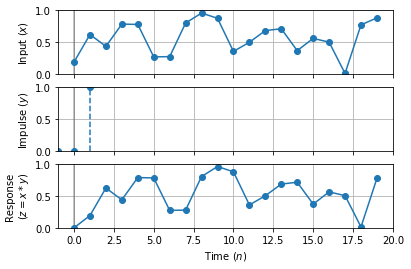

In [6]:
convolution_weighted_sum(20, 0, 0, 1)

As we can see, the effect of $y$ is to delay $x$ in time, by always causing $z_m = x_{m-1}$

### Feature detection

When seeing convolution as a [weighted sum](#Weighted-sum), we added the restriction

$$
\sum_{n=-\infty}^{\infty} y_n = 1
$$

If we relax this constraint, we get a class of more interesting tamplates that can act as feature detectors.

#### Edge detection (derivatives)

[Source](https://en.wikipedia.org/wiki/Edge_detection). The derivative of continuous function $x(t)$ is defined as

$$\frac{{\rm d}x}{{\rm d}t} = \lim_{\Delta t \rightarrow 0} \frac{x(t + \Delta t) - x(t - \Delta t)}{2 \Delta t}$$

If we discretize time as $t = n\Delta t$, then the derivative can be approximated, in the discrete domain as $\frac{x_{n+1} - x_{n-1}}{2}$, which corresponds to the kernel $y = \left\{ \frac{1}{2}, 0, -\frac{1}{2} \right\}$.

In [7]:
def convolution_edge_first_order(n, seed=1234):
    npr.seed(seed)
    
    x = npr.random(n)
    y = np.array([0.5, 0, -0.5])
    z = np.convolve(x, y, mode='same')
    
    fig = plt.figure()
    axes = fig.subplots(3, 1, sharex=True, sharey=True)
    
    for ax in axes:
        ax.axvline(0, color='k', alpha=0.3)
        ax.set_xlim(-1, n)
        ax.set_ylim(-1, 1)
        ax.grid()
    
    axes[0].plot(x, 'o-')
    axes[0].set_ylabel('Input ($x$)')
    
    axes[1].stem([-1, 0, 1], y, basefmt='none', linefmt='C0--', markerfmt='o')
    axes[1].set_ylabel('Impulse ($y$)')
    
    axes[2].plot(z, 'o-')
    axes[2].set_xlabel('Time ($n$)')
    axes[2].set_ylabel('Response\n($z=x * y$)')
    
    plt.show(fig)
    plt.close(fig)
    
ipw.interact(
    convolution_edge_first_order,
    n=ipw.IntText(10, description='Points:'),
    seed=ipw.IntText(1234, description='Rand. seed'),
)

interactive(children=(IntText(value=10, description='Points:'), IntText(value=1234, description='Rand. seed'),…

<function __main__.convolution_edge_first_order(n, seed=1234)>

We can see from the plot above that $z$ is only positive for points $x_m$ having a positive difference between their neighbors, that is, $x_{m+1} - x_{m-1} > 0$. It is also possible to derive a second order approximation for the derivative, resulting in $y = \left\{ 1, -2, 1 \right\}$.

In [8]:
def convolution_edge_second_order(n, seed=1234):
    npr.seed(seed)
    
    x = 2 * npr.random(n) - 1
    y = np.array([1, -2, 1])
    z = np.convolve(x, y, mode='same')
    
    fig = plt.figure()
    axes = fig.subplots(3, 1, sharex=True, sharey=True)
    
    for ax in axes:
        ax.axvline(0, color='k', alpha=0.3)
        ax.set_xlim(-1, n)
        ax.set_ylim(-2, 2)
        ax.grid()
    
    axes[0].plot(x, 'o-')
    axes[0].set_ylabel('Input ($x$)')
    
    axes[1].stem([-1, 0, 1], y, basefmt='none', linefmt='C0--', markerfmt='o')
    axes[1].set_ylabel('Impulse ($y$)')
    
    axes[2].plot(z, 'o-')
    axes[2].set_xlabel('Time ($n$)')
    axes[2].set_ylabel('Response\n($z=x * y$)')
    
    plt.show(fig)
    plt.close(fig)
    
ipw.interact(
    convolution_edge_second_order,
    n=ipw.IntText(10, description='Points:'),
    seed=ipw.IntText(1234, description='Rand. seed'),
)

interactive(children=(IntText(value=10, description='Points:'), IntText(value=1234, description='Rand. seed'),…

<function __main__.convolution_edge_second_order(n, seed=1234)>

## Correlation examples

Let us make the same assumptions as for the [convolution examples](#Convolution-examples), that is, everything will be real-valued, discrete domain. __Note:__ Scipy's [definition](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html) of cross-correlation considers the _lag_ $\tau$ in the opposite sense of what we do here. Their definition is

$$(f \star g)(\tau) = \int_{-\infty}^{\infty} f^{*}(t) g(t - \tau) {\rm d}t$$

If we perform lag analysis in order to determine if $g$ is a delayed copy $f$, and define $\tau_{\rm max} = {\rm argmax}_{\tau} (f \star g)$, we get:

* If $\tau_{\rm max} > 0$ then $f$ is delayed in relation to $g$
* If $\tau_{\rm max} < 0$ then $g$ is delayed in relation to $f$

Which is rather strange, unless we intepret that `scipy.signal.correlate(f, g)` means $(g \star f)$ and not $(f \star g)$ which, again, is rather strange. Hence, throughout this presentation, we will invert the results of the `scipy.signal.correlate` function in order to preserve our original definition of

$$(f \star g)(\tau) = \int_{-\infty}^{\infty} f^{*}(t) g(t + \tau) {\rm d}t$$

for which lag analysis gives us that

* If $\tau_{\rm max} > 0$ then $g$ is delayed in relation to $f$
* If $\tau_{\rm max} < 0$ then $f$ is delayed in relation to $g$

### Positive lag analysis

In this example, we'll produce a signal $x$ 

In [9]:
def correlation_positive_lag(n, lag, noise, seed=1234):
    t = np.arange(n)
    
    x = np.cos(2 * np.pi * 4 * t / n) * np.exp(-2 * t / n)
    y = np.hstack([
        noise * (2 * npr.random(lag) - 1),
        x[:n-lag] * (1 + noise * (2 * npr.random(n-lag) - 1))
    ])
    z = ss.correlate(x, y)[::-1] / len(x)
    tt = np.arange(-len(z)//2, len(z)//2)
    
    fig = plt.figure()
    axes = fig.subplots(3, 1, sharex=True, sharey=True)
    
    for ax in axes:
        ax.axvline(0, color='k', alpha=0.3)
        ax.grid()
    
    axes[0].plot(x)
    axes[0].set_ylabel('Input ($x$)')
    
    axes[1].plot(y)
    axes[1].set_ylabel('Input ($y$)')
    
    axes[2].plot(tt, z)
    axes[2].set_xlabel('Time/lag ($n$)')
    axes[2].set_ylabel('Cross-correlation\n($z=x \star y$)')
    axes[2].axvline(tt[np.argmax(z)], linestyle='--')
    
    plt.show(fig)
    plt.close(fig)
    
ipw.interact(
    correlation_positive_lag,
    n=ipw.IntText(100, description='Points:'),
    lag=ipw.IntText(10, description='y delay:'),
    noise=ipw.FloatText(0.25, description='Noise ratio:'),
    seed=ipw.IntText(1234, description='Rand. seed:'),
)

interactive(children=(IntText(value=100, description='Points:'), IntText(value=10, description='y delay:'), Fl…

<function __main__.correlation_positive_lag(n, lag, noise, seed=1234)>

## TODO

* Explicitly list references
    * Insert additional ones
* More examples
    * Mixed examples (correlation and convolution)
    * Complex functions
* Additional discussions
    * Normalized correlation
    * First-order signal reconstruction

In [10]:
headerfooter.footer()